In [270]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import date
import pandas as pd
from pandas_datareader import data 
import matplotlib.pyplot as plt
from datetime import date

sns.set(style='darkgrid', context='talk', palette='Dark2')

Example of web scrapping on Microsoft

In [271]:
today = date.today()
end_date = today.strftime("%Y-%m-%d")

In [272]:
start_date = '2000-01-01'
# end_date = '2022-10-31'
microsoft = data.DataReader('MSFT', 'yahoo', start_date, end_date)
# data.get_quote_yahoo('MSFT')['marketCap']
microsoft

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2000-01-03,59.312500,56.000000,58.687500,58.281250,53228400.0,36.932102
2000-01-04,58.562500,56.125000,56.781250,56.312500,54119000.0,35.684532
2000-01-05,58.187500,54.687500,55.562500,56.906250,64059600.0,36.060772
2000-01-06,56.937500,54.187500,56.093750,55.000000,54976600.0,34.852810
2000-01-07,56.125000,53.656250,54.312500,55.718750,62013600.0,35.308266
...,...,...,...,...,...,...
2022-10-28,236.600006,226.050003,226.240005,235.869995,40647700.0,235.869995
2022-10-31,234.919998,231.149994,233.759995,232.130005,28357300.0,232.130005
2022-11-01,235.740005,227.330002,234.600006,228.169998,30592300.0,228.169998


Having imported the appropriate tools, getting market data from a free online source, such as Yahoo Finance, is super easy. Since pandas has a simple remote data access for the Yahoo Finance API data, this is as simple as:

In [273]:
def web_scraper():

    tickers = pd.read_csv("CSV/constituents.csv")
    tickers_symbol = tickers['Symbol']

    # Define the instruments to download. We would like to see Apple, Microsoft and the S&P500 index.
    # tickers = ['AAPL', 'MSFT', 'GOOG', 'META']

    # We would like all available data from 01/01/2000 until 2022-10-31.
    start_date = '2013-01-01'
    today = date.today()
    end_date = today.strftime("%Y-%m-%d")

    # User pandas_reader.data.DataReader to load the desired data.
    df = data.DataReader(tickers_symbol, 'yahoo', start_date, end_date) # I commented this line because I saved the scrapped data into a .csv
    # microsoft = data.DataReader('MSFT', 'yahoo', start_date, end_date)
    close = df['Close']
    volume = df['Volume']

    #Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

    #Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')
    # close.set_index(microsoft.index)    
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')
    # volume.set_index(microsoft.index)   
    df = df.reindex(all_weekdays)
    df = df.fillna(method='ffill')  

    # df.to_csv("CSV/sp500.csv",index=False)
    # close.to_csv("CSV/sp500-close.csv",index=False)
    # volume.to_csv("CSV/sp500-volume.csv", index=False)

    df.to_csv("CSV/sp5002.csv",index=False)
    close.to_csv("CSV/sp5002-close.csv",index=False)
    volume.to_csv("CSV/sp5002-volume.csv", index=False)

In [274]:
# web_scraper()

In [275]:
sp500 = pd.read_csv("CSV/sp5002.csv")
close = pd.read_csv("CSV/sp5002-close.csv")
volume = pd.read_csv("CSV/sp5002-volume.csv")

/home/joaodocarglass/anaconda3/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,2

#### Preparing the Data

Let us assume we are interested in working with the Close prices which have been already been adjusted by Yahoo finance to account for stock splits. We want to make sure that all weekdays are included in our dataset, which is very often desirable for quantitative trading strategies.

Of course, some of the weekdays might be public holidays in which case no price will be available. For this reason, we will fill the missing prices with the latest available prices:

Let's build a function to drop columns with nulls percentage above 25

In [276]:
def drop_null_columns(data):
    nulls_percent_df = pd.DataFrame(data.isna().sum()/len(data)).reset_index()
    nulls_percent_df.columns = ['column_name', 'nulls_percentage']
    # nulls_percent_df.head()
    columns_above_threshold = nulls_percent_df[nulls_percent_df['nulls_percentage']>0]
    # print(len(columns_above_threshold['column_name']))
    drop_columns_list = list(columns_above_threshold['column_name'])
    # print(drop_columns_list)
    data = data.drop(columns=drop_columns_list)
    data.shape
    return data

In [277]:
close.isna().sum()

MMM        0
AOS        0
ABT        0
ABBV    3392
ABMD       0
        ... 
KSU     5959
PBCT    5959
VIAC    5959
WLTW    5959
XLNX    5959
Length: 505, dtype: int64

In [278]:
close = drop_null_columns(close)

In [279]:
volume = drop_null_columns(volume)

In [280]:
close.isna().sum()

MMM     0
AOS     0
ABT     0
ABMD    0
ATVI    0
       ..
WMB     0
XEL     0
YUM     0
ZBRA    0
ZION    0
Length: 364, dtype: int64

#### Now we are going to create 100 random portfolios for the close and the volume
#### Each sample will be of 5 samples from the whole population

In [281]:
close

,MMM,AOS,ABT,ABMD,ATVI,ADM,ADBE,AMD,AES,AFL,...,WELL,WST,WDC,WY,WHR,WMB,XEL,YUM,ZBRA,ZION
0,47.187500,3.614583,15.711531,18.250000,1.369792,10.884354,16.390625,15.500000,36.250000,11.187500,...,15.375000,7.562500,3.937500,69.875000,61.812500,23.198961,19.000000,6.706057,25.027779,55.500000
1,45.312500,3.562500,15.262630,17.812500,1.328125,10.770975,15.015625,14.625000,34.812500,10.890625,...,15.312500,7.640625,4.687500,67.250000,59.437500,22.684469,19.437500,6.571262,24.666668,52.812500
2,46.625000,3.552083,15.234574,18.000000,1.333333,10.600907,15.312500,15.000000,35.187500,10.828125,...,15.750000,7.609375,4.375000,70.812500,60.312500,24.087631,20.187500,6.604960,25.138889,52.750000
3,50.375000,3.500000,15.767643,18.031250,1.307292,10.657596,15.437500,16.000000,35.468750,11.046875,...,16.562500,7.531250,4.562500,74.125000,60.812500,24.602125,20.000000,6.548796,23.777779,53.500000
4,51.375000,3.645833,15.935981,17.937500,1.343750,10.827664,16.187500,16.250000,36.156250,11.265625,...,16.812500,7.609375,5.625000,71.687500,61.000000,25.256933,20.000000,6.402768,23.513889,53.625000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5954,126.599998,54.380001,99.489998,258.059998,72.849998,94.879997,325.679993,62.009998,26.459999,64.790001,...,61.500000,225.509995,35.500000,31.100000,139.910004,32.669998,65.370003,117.879997,288.000000,51.540001
5955,125.790001,54.779999,98.940002,252.080002,72.800003,96.980003,318.500000,60.060001,26.160000,65.110001,...,61.040001,230.100006,34.369999,30.930000,138.240005,32.730000,65.110001,118.250000,283.220001,51.939999
5956,125.300003,54.599998,99.309998,377.820007,73.309998,97.529999,316.019989,59.660000,26.340000,66.809998,...,60.099998,229.500000,35.700001,30.389999,137.369995,33.439999,65.900002,118.150002,238.300003,51.610001
5957,122.860001,53.700001,98.040001,373.510010,72.660004,95.800003,301.220001,58.630001,25.830000,66.690002,...,58.860001,219.529999,34.580002,29.660000,131.619995,33.040001,65.309998,117.370003,236.029999,49.490002


In [282]:
all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency

microsoft = microsoft.reindex(all_weekdays)
microsoft = microsoft.fillna(method='ffill')

In [283]:
from sklearn.preprocessing import MinMaxScaler
def EscaladorMinMax(data, MinMaxtransformer):
    X_normalized = MinMaxtransformer.transform(data)
    print(X_normalized.shape)
    X_normalized = pd.DataFrame(X_normalized,columns=data.columns)
    return X_normalized

In [284]:
MinMaxtransformer = MinMaxScaler().fit(close) # Only run once
# Ahora habría que llamar a la función

In [285]:
X_train_num_scaled = EscaladorMinMax(close, MinMaxtransformer)

(5959, 364)


In [286]:
# microsoft.index

In [287]:
close.set_index(microsoft.index, inplace=True)
volume.set_index(microsoft.index, inplace=True)

In [288]:
def random_portfolios(data):
    import random
    list_of_portfolios = []
    tickers_data = list(data.columns.values)
    for i in range(10000):
        portofolio_aleatorio = random.sample(tickers_data, 5)
        list_of_portfolios.append(data[portofolio_aleatorio])
    return list_of_portfolios

In [289]:
list_of_portfolios_close = random_portfolios(X_train_num_scaled)

In [290]:
list_of_portfolios_volume = random_portfolios(volume)

In [291]:
list_of_portfolios_close[0]

,GPC,IP,PXD,ABT,GD
0,0.033852,0.830518,0.005612,0.018827,0.025972
1,0.032296,0.808305,0.006061,0.015324,0.030413
2,0.031518,0.838596,0.005163,0.015105,0.037949
3,0.031518,0.856770,0.005837,0.019264,0.038353
4,0.041245,0.881002,0.006735,0.020578,0.041448
...,...,...,...,...,...
5954,0.997572,0.518955,0.899535,0.672522,1.000000
5955,0.991346,0.515323,0.896302,0.668231,0.996038
5956,1.000000,0.513939,0.883802,0.671118,0.996512
5957,0.973977,0.499927,0.883766,0.661208,0.981268


In [292]:
list_of_portfolios_close[0]

,GPC,IP,PXD,ABT,GD
0,0.033852,0.830518,0.005612,0.018827,0.025972
1,0.032296,0.808305,0.006061,0.015324,0.030413
2,0.031518,0.838596,0.005163,0.015105,0.037949
3,0.031518,0.856770,0.005837,0.019264,0.038353
4,0.041245,0.881002,0.006735,0.020578,0.041448
...,...,...,...,...,...
5954,0.997572,0.518955,0.899535,0.672522,1.000000
5955,0.991346,0.515323,0.896302,0.668231,0.996038
5956,1.000000,0.513939,0.883802,0.671118,0.996512
5957,0.973977,0.499927,0.883766,0.661208,0.981268


In [293]:
best_portfolio_values = [0]
best_portfolio = []
for x in range(10000):
    stock_performance = []
    for i in list_of_portfolios_close[x]:
        stock_performance.append(list_of_portfolios_close[x][i][-1:].values[0] - list_of_portfolios_close[x][i][0:].values[0])
    
    if np.mean(best_portfolio_values) < np.mean(stock_performance):
        best_portfolio_values = stock_performance
        best_portfolio = list_of_portfolios_close[x].columns


best_portfolio_values, best_portfolio

([0.9574577790067748,
  0.9524513808669747,
  0.9240200383527406,
  0.7441460325158564,
  0.9883311837188682],
 Index(['HES', 'GPC', 'GL', 'AON', 'LMT'], dtype='object'))

In [294]:
best = pd.DataFrame(best_portfolio_values, best_portfolio).T
best

,HES,GPC,GL,AON,LMT
0,0.957458,0.952451,0.92402,0.744146,0.988331


In [295]:
# stock_performance = list_of_portfolios[0]['GLW'][-1:].values[0] - list_of_portfolios[0]['GLW'][0:].values[0]

In [296]:
def close_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


In [297]:
def close_print2(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    close = df['Close']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    close = close.reindex(all_weekdays)
    close = close.fillna(method='ffill')

    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = close.loc[:, i]

        # Calculate the 20 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=20).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='20 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Adjusted closing price ($)')
        ax.legend()
    close.to_csv("CSV/close.csv", index=True)


#### What does moving average tells us?
A moving average (MA) is a stock indicator commonly used in technical analysis, used to help smooth out price data by creating a constantly updated average price. A rising moving average indicates that the security is in an uptrend, while a declining moving average indicates a downtrend.

In [298]:
close[best.columns]

,HES,GPC,GL,AON,LMT
2000-01-03,18.166668,24.062500,12.583333,39.000000,20.250000
2000-01-04,17.812500,23.812500,12.333333,38.125000,20.937500
2000-01-05,17.666668,23.687500,12.333333,39.250000,21.062500
2000-01-06,18.041668,23.687500,12.305556,40.625000,21.375000
2000-01-07,18.812500,25.250000,12.555556,42.750000,21.437500
...,...,...,...,...,...
2022-10-28,140.470001,178.860001,113.709999,289.200012,484.869995
2022-10-31,141.080002,177.860001,115.519997,281.489990,486.679993
2022-11-01,143.300003,179.250000,114.199997,284.489990,485.630005
2022-11-02,140.399994,175.070007,112.260002,279.130005,482.059998


In [299]:
# close_print(close[best.columns].columns)

In [300]:
def volume_print(stock_symbol):
    
    df = data.DataReader(stock_symbol, 'yahoo', start_date, end_date)
    volume = df['Volume']
    all_weekdays = pd.date_range(start=start_date, end=end_date, freq='B')  # B stands for business day frequency
    volume = volume.reindex(all_weekdays)
    volume = volume.fillna(method='ffill')


    for i in stock_symbol:
        # Get the ticker timeseries. This now returns a Pandas Series object indexed by date.
        ticker = volume.loc[:, i]

        # Calculate the 30 and 100 days moving averages of the closing prices
        short_rolling_ticker = ticker.rolling(window=30).mean()
        long_rolling_ticker = ticker.rolling(window=100).mean()

        # short_rolling_ticker = ticker.rolling(window=30, center=True).mean()
        # long_rolling_ticker = ticker.rolling(window=100, center=True).mean()

        # Plot everything by leveraging the very powerful matplotlib package
        fig, ax = plt.subplots(figsize=(18,11))

        plt.title(i)

        ax.plot(ticker.index, ticker, label=i)
        ax.plot(short_rolling_ticker.index, short_rolling_ticker, label='30 days rolling')
        ax.plot(long_rolling_ticker.index, long_rolling_ticker, label='100 days rolling')

        ax.set_xlabel('Date')
        ax.set_ylabel('Stock Volume')
        ax.legend()

    volume.to_csv("CSV/volume.csv", index=True)


In [301]:
# volume_print(best.columns)

In [302]:
close[best.columns]

,HES,GPC,GL,AON,LMT
2000-01-03,18.166668,24.062500,12.583333,39.000000,20.250000
2000-01-04,17.812500,23.812500,12.333333,38.125000,20.937500
2000-01-05,17.666668,23.687500,12.333333,39.250000,21.062500
2000-01-06,18.041668,23.687500,12.305556,40.625000,21.375000
2000-01-07,18.812500,25.250000,12.555556,42.750000,21.437500
...,...,...,...,...,...
2022-10-28,140.470001,178.860001,113.709999,289.200012,484.869995
2022-10-31,141.080002,177.860001,115.519997,281.489990,486.679993
2022-11-01,143.300003,179.250000,114.199997,284.489990,485.630005
2022-11-02,140.399994,175.070007,112.260002,279.130005,482.059998


mean : 54.32402422028433
mean : 65.58371967252299
mean : 44.90810977318359
mean : 86.9295050300474
mean : 160.11538742252355


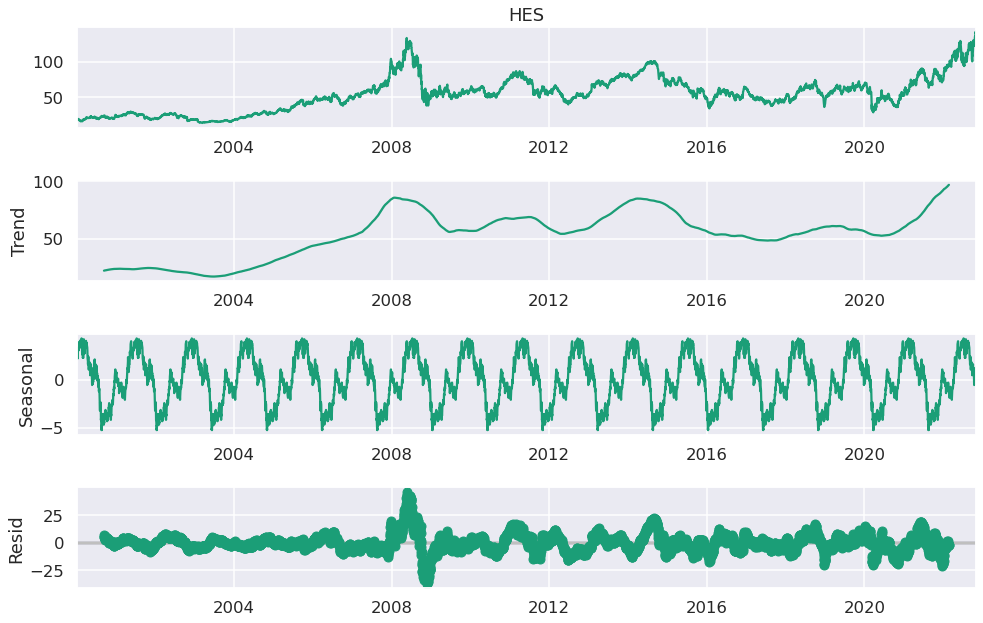

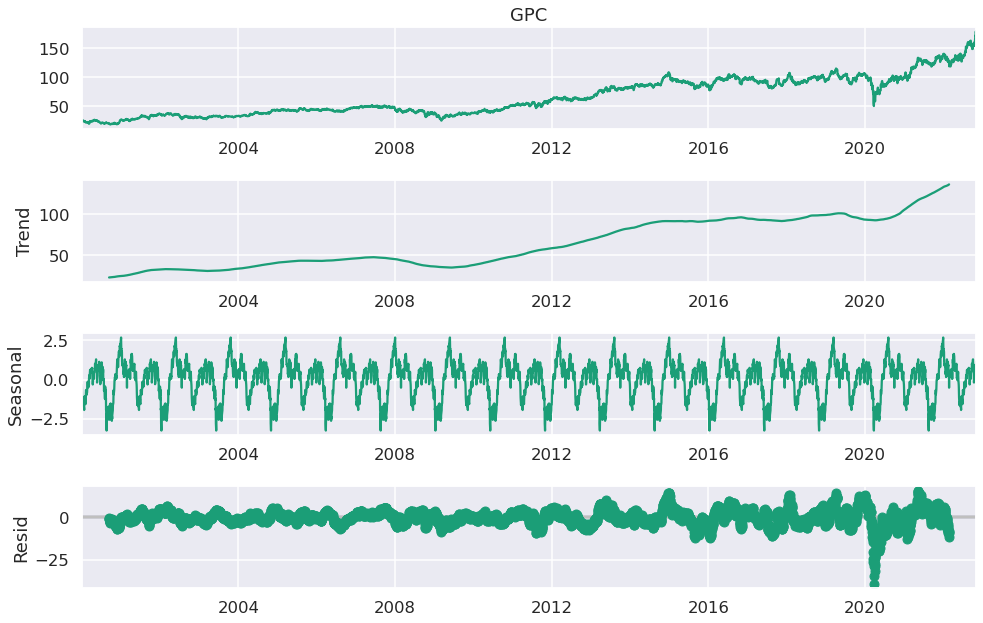

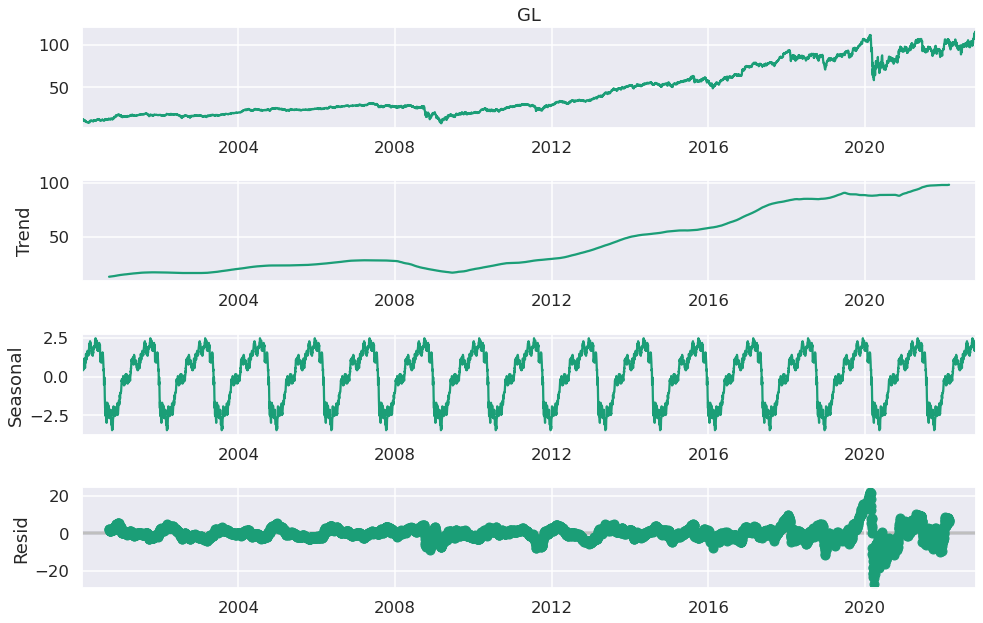

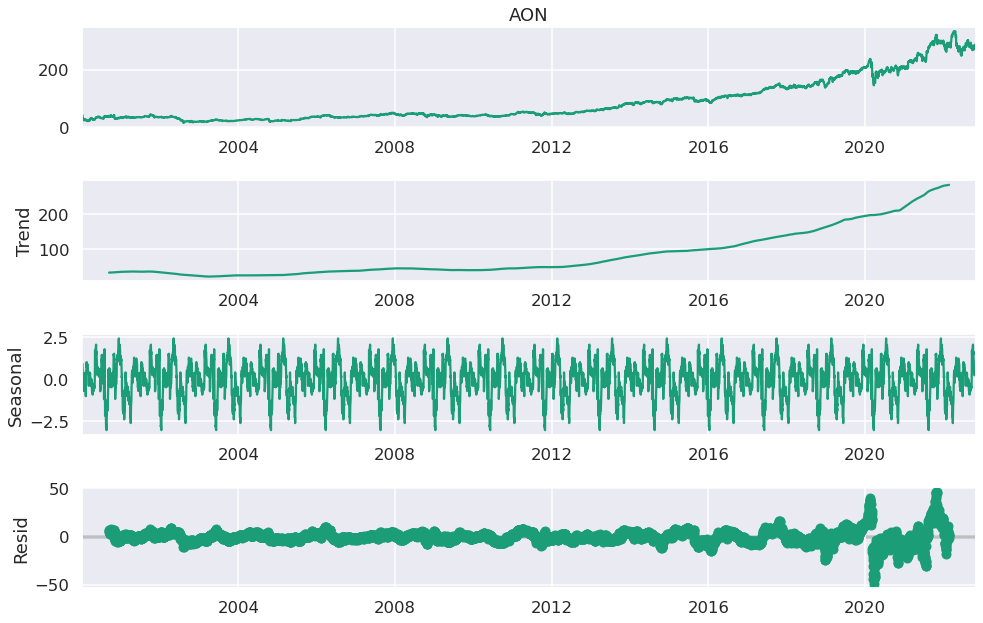

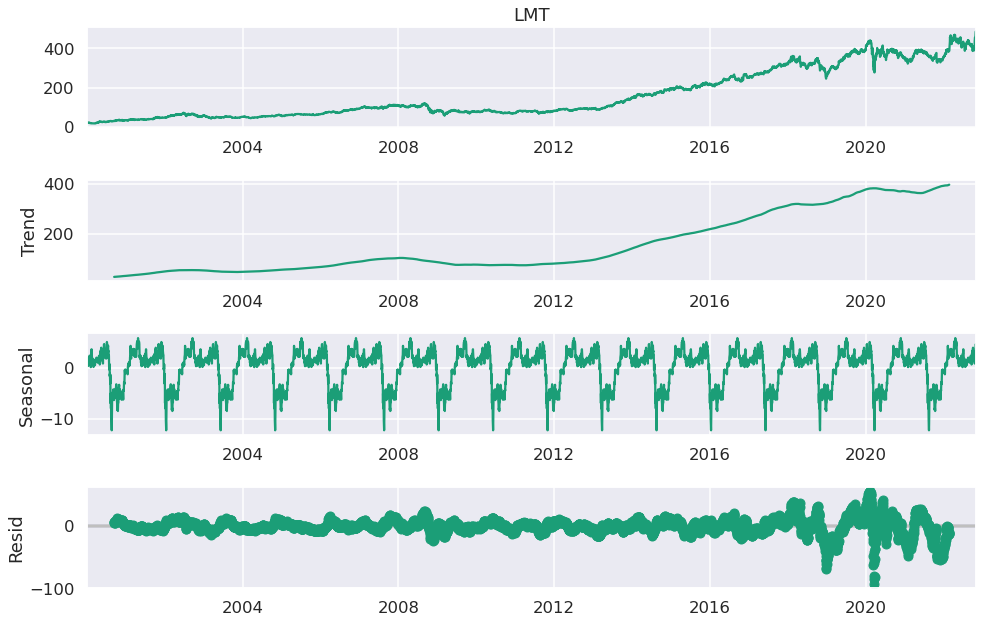

In [303]:
import statsmodels.api as sm

for i in range(len(best.columns)):
    print('mean :' , close[best.columns[i]].mean())
    res = sm.tsa.seasonal_decompose(close[best.columns[i]], period=365 * 1) # Half the total
    resplot = res.plot()
    resplot.set_size_inches((14,9))
    resplot.tight_layout()



In [304]:
# import statsmodels.api as sm
# print('mean :' , close['TRV'].mean())
# res = sm.tsa.seasonal_decompose(close['TRV'])
# resplot = res.plot()
# resplot.set_size_inches((14,9))
# resplot.tight_layout()

In [305]:
close[best.columns].columns[0]

'HES'

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


HES


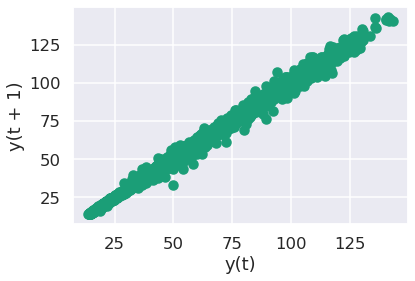

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


GPC


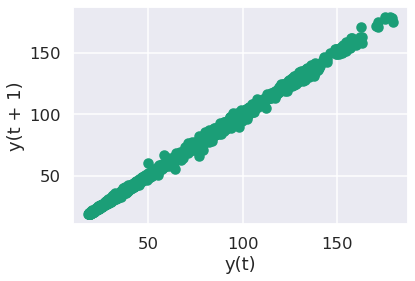

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


GL


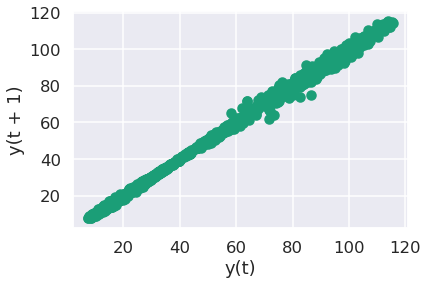

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


AON


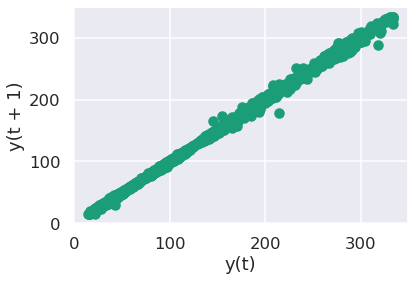

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


LMT


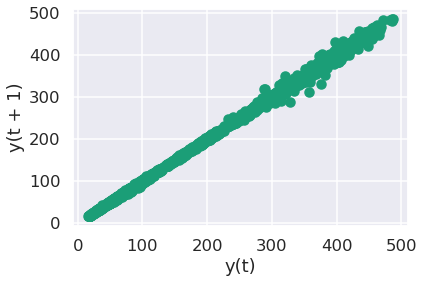

In [306]:
from pandas.plotting import lag_plot
for i in range(len(best.columns)):
    print(close[best.columns].columns[i])
    lag_plot(close[best.columns[i]]).plot
    plt.show()

In [307]:
from sklearn.preprocessing import MinMaxScaler
import math

close_prices = close[best.columns[0]]
values = close_prices.values
training_data_len = math.ceil(len(values)* 0.95)
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(values.reshape(-1,1))
train_data = scaled_data[0: training_data_len, :]
x_train = []
y_train = []
for i in range(30, len(train_data)):
    x_train.append(train_data[i-30:i, 0])
    y_train.append(train_data[i, 0])
    
x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
test_data = scaled_data[training_data_len-30: , : ]
x_test = []
y_test = values[training_data_len:]
for i in range(30, len(test_data)):
    x_test.append(test_data[i-30:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [308]:
# y_test

In [309]:
import tensorflow as tf 
from tensorflow import keras
from tensorflow.keras import layers

In [310]:
model = keras.Sequential()
model.add(layers.LSTM(100, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(layers.LSTM(100, return_sequences=False))
model.add(layers.Dense(25))
model.add(layers.Dense(1))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 30, 100)           40800     
                                                                 
 lstm_11 (LSTM)              (None, 100)               80400     
                                                                 
 dense_10 (Dense)            (None, 25)                2525      
                                                                 
 dense_11 (Dense)            (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [311]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size= 32, epochs=3)

Epoch 1/3
176/176 [==============================] - 7s 23ms/step - loss: 0.0033
Epoch 2/3
176/176 [==============================] - 4s 25ms/step - loss: 5.0246e-04
Epoch 3/3
176/176 [==============================] - 4s 24ms/step - loss: 4.3224e-04


In [312]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)
rmse = np.sqrt(np.mean(predictions - y_test)**2)
# rmse

10/10 [==============================] - 1s 8ms/step


In [313]:
best.columns[0]

'HES'

/tmp/ipykernel_5446/2417649685.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  validation['Predictions'] = predictions


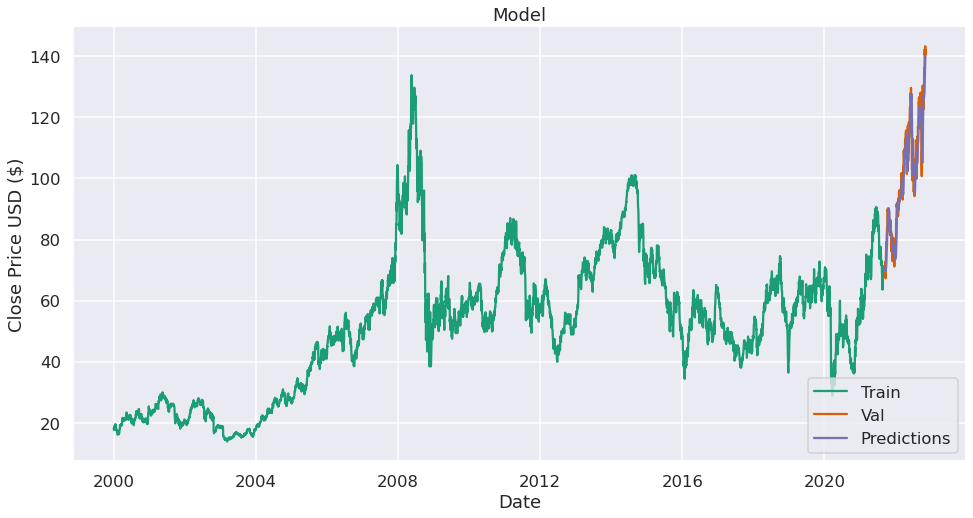

In [314]:
data = close.filter([best.columns[0]])
train = data[:training_data_len]
validation = data[training_data_len:]
validation['Predictions'] = predictions
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel('Date')
plt.ylabel('Close Price USD ($)')
plt.plot(train)
plt.plot(validation[[best.columns[0], 'Predictions']])
plt.legend(['Train', 'Val', 'Predictions'], loc='lower right')
plt.show()
